# Security Investments (ROSI)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [2]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('../data_with_ports.csv.gz', sep='|', compression='gzip')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [4]:
# subset hosting providers only
dfASesHosting = df.loc[df["as_type"] == "hosting"]
#dfASesHosting.info() # premilary inspection

# drop columns with all null values
dfASesHosting.drop(columns=["tg_op", "subs"], inplace=True)

# fix null values in `region`
dfASesHosting[dfASesHosting.region.isna()][["cc", "region"]].drop_duplicates() # found US and CA have region = NaN
dfASesHosting.region.fillna("NA", inplace=True) # NA = North America

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
dfASesHosting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473792 entries, 2948 to 5697809
Data columns (total 33 columns):
target_ip                 473792 non-null object
date                      473792 non-null datetime64[ns]
sensor_id                 473792 non-null object
service                   473792 non-null object
start_time                473792 non-null datetime64[ns]
stop_time                 473792 non-null datetime64[ns]
duration                  473792 non-null float64
packets                   473792 non-null int64
raw_country               473792 non-null object
raw_as                    473792 non-null object
raw_hostname              473792 non-null object
udp_port_list             473792 non-null object
pyasn_as                  473792 non-null float64
pyasn_as_bgp_size         472991 non-null float64
cc                        473792 non-null object
region                    473792 non-null object
is_oecd                   473792 non-null float64
as_type                  

In [6]:
from random import randint

dfASesHosting.iloc[randint(0, len(dfASesHosting))]

target_ip                          190.210.177.182
date                           2015-01-03 00:00:00
sensor_id                                sensor005
service                                       ssdp
start_time                     2015-01-03 16:22:55
stop_time                      2015-01-03 16:44:03
duration                                      1268
packets                                        584
raw_country                              Argentina
raw_as                                AS16814 S.A.
raw_hostname                                  None
udp_port_list                           [80, 7667]
pyasn_as                                     16814
pyasn_as_bgp_size                           158720
cc                                              AR
region                                          LC
is_oecd                                          0
as_type                                    hosting
as_type_confidence                               1
org                         Jua

## Metadata

Decsriptions of the metadata (Cheung, 2017):

| Column | Description |
| ------ | ----------- |
| `target_ip` | The IP address that has been targeted by a DDoS attackc |
| `date` | The date of attack |
| `sensor_id` | The name of the honeypot that monitored the attack traffic |
| `service` | The protocol that was used to execute the attack |
| `start_time` | The start time of the attack |
| `stop_time` | The stop time of the attack |
| `duration` | Attack duration |
| `pyasn_as` | The autonomous system number identifying which AS is routing traffic for the attacked IP |
| `pyasn_as_bpg_size` | The total number of IP addresses that the AS routes |
| `cc` | Short form of the country where the IP address seems to reside |
| `as_type` | The type of the Autonomous system (could be ISP, Hosting, EDU, etc.) |
| `tg_op` | A string identifier to ASes that are known to be Broadband ISPs |
| `caida_type` | A type identifier for ASes based on different source (CAIDA) |
| `dc` | The number of second level domains that have been observed to map to the attacked IP addresses in DNS traffic |
| `subs` | The number of subscribers for those ASes that are known to be Broadband ISPs |
| `as_ipsize_seen` | The total number of IP addresses of the AS that have been observed to be routed to IPs of the AS in DNS traffic |
| `as_domainsize_seen` | The total number of second level domains that have been observed to be routed to IPs of the AS in DNS traffic |
| `year` | The year of the attack |
| `udp_port_list` | The ports that attack packets have been sent to |


# ROSI

In [7]:
dfROSI = dfASesHosting.copy()

In [8]:
dfROSI.loc[:, "costs_org_domain_per_second"] = dfROSI["as_domainsize_seen"] * 29.15

In [9]:
dfROSI.loc[:, "total_costs_attack"] = dfROSI.duration * dfROSI.costs_org_domain_per_second

In [10]:
dfROSI.loc[:, "risk_height"] = 0.17 * dfROSI.total_costs_attack
dfROSI.loc[:, "maximum_investment"] = 0.01 * dfROSI.total_costs_attack

In [11]:
df_mean_attacks = dfROSI.groupby("org").mean()

In [12]:
df_mean_attacks[df_mean_attacks.index.isin(["AMAZON"])]

,duration,packets,pyasn_as,pyasn_as_bgp_size,is_oecd,as_type_confidence,org_rangesize,org_ipsize_seen,org_domainsize_seen,org_ipsize_seen_shared,org_is_hosting,dc,as_ipsize_seen,as_domainsize_seen,pps,year,costs_org_domain_per_second,total_costs_attack,risk_height,maximum_investment
org,,,,,,,,,,,,,,,,,,,,
AMAZON,1173.511503,7995.733012,15036.873194,4.683955e+06,1.0,2.947566,2294716.0,158265.0,334952.0,2991.0,1.0,107.777956,783851.975923,4.072161e+06,inf,2015.0,1.187035e+08,1.403230e+11,2.385491e+10,1.403230e+09


In [14]:
df_mean_attacks[df_mean_attacks.index.str.contains("amazon", case=False)]

,duration,packets,pyasn_as,pyasn_as_bgp_size,is_oecd,as_type_confidence,org_rangesize,org_ipsize_seen,org_domainsize_seen,org_ipsize_seen_shared,org_is_hosting,dc,as_ipsize_seen,as_domainsize_seen,pps,year,costs_org_domain_per_second,total_costs_attack,risk_height,maximum_investment
org,,,,,,,,,,,,,,,,,,,,
AMAZON,1173.511503,7995.733012,15036.873194,4.683955e+06,1.0,2.947566,2.294716e+06,158265.0,334952.0,2991.0,1.0,107.777956,783851.975923,4.072161e+06,inf,2015.000000,1.187035e+08,1.403230e+11,2.385491e+10,1.403230e+09
Amazon,649.899225,3591.000000,14691.294574,4.467533e+06,1.0,2.984496,2.294724e+06,NaN,NaN,NaN,0.0,4.279070,754614.124031,4.180510e+06,11.490816,2014.000000,1.218619e+08,7.849611e+10,1.334434e+10,7.849611e+08
Amazon Data Services Ireland Ltd,159.611111,352.388889,16509.000000,5.605888e+06,1.0,3.000000,3.766400e+04,947.0,1033.0,18.0,1.0,1.111111,908402.000000,3.610604e+06,11.515217,2015.000000,1.052491e+08,1.679893e+10,2.855818e+09,1.679893e+08
Amazon Technologies,861.360544,26389.364431,15132.557823,4.743879e+06,1.0,2.986395,2.681888e+06,79.0,28.0,NaN,1.0,186.807580,791947.421769,4.042160e+06,inf,2015.000000,1.178290e+08,1.009974e+11,1.716955e+10,1.009974e+09
"Amazon Web Services, Elastic Compute Cloud, EC2, E",1244.750842,98375.164983,16509.000000,5.605888e+06,1.0,3.000000,1.023993e+05,16773.0,490119.0,1121.0,1.0,1538.680135,908402.000000,3.610604e+06,18.166269,2014.723906,1.052491e+08,1.310089e+11,2.227152e+10,1.310089e+09
Amazon.com,1288.522389,18324.597661,14963.841240,4.638218e+06,1.0,2.977130,9.015952e+06,844486.0,5390994.0,52585.0,1.0,1063.379024,777673.070979,4.095058e+06,inf,2014.766339,1.193709e+08,1.551136e+11,2.636931e+10,1.551136e+09


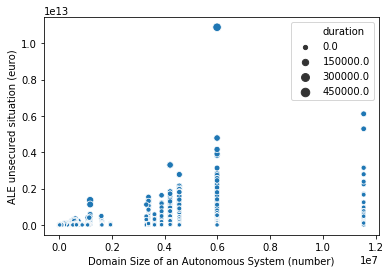

In [17]:
ax = sns.scatterplot(x="as_domainsize_seen", y="risk_height", size="duration", data=dfROSI)
ax.set_xlabel("Domain Size of an Autonomous System (number)")
ax.set_ylabel("ALE unsecured situation (euro)")
plt.show()

In [ ]:
def secondLevelDomainName(raw_hostname):
    '''get second-level domain name'''
    if raw_hostname.count(".") >= 2:
        d3, d2, d1 = raw_hostname.rsplit(".", 2)
        if (d2 == "com") | (d2 == "co"): # e.g. "co.uk" or "com.br" 
            return raw_hostname
        else:
            return d2 + "." + d1
    else:
        return raw_hostname

In [ ]:
hostingDomains = dfASesHosting[~dfASesHosting.raw_hostname.isna()]
hostingDomains = hostingDomains[hostingDomains.raw_hostname != "None"]
hostingDomains['hostname'] = hostingDomains.raw_hostname.apply(secondLevelDomainName)
hostingDomains.head()

In [ ]:
# top ten hosting providers under most attacks
mostAttackedHostingProviders = hostingDomains.hostname.value_counts()[:10]
mostAttackedHostingProviders

In [ ]:
hostingDomainsMostAttacked = hostingDomains[hostingDomains.hostname.isin(mostAttackedHostingProviders.index.tolist())]
hostingDomainsMostAttacked.sort_values(by="hostname")

In [ ]:
hostingDomainsMostAttacked_mean = hostingDomainsMostAttacked.groupby("org").mean()

In [ ]:
hostingDomainsMostAttacked_mean.index.unique()

In [ ]:
file2write=open("all_orgs",'w')
file2write.write(str(hostingDomainsMostAttacked_mean.index.unique()))
file2write.close()

In [ ]:
hostingDomainsMostAttacked_mean[hostingDomainsMostAttacked_mean.index.isin(["AMAZON", "softlayer.com", ])]

## Hosting providers

In [ ]:
def secondLevelDomainName(raw_hostname):
    '''get second-level domain name'''
    if raw_hostname.count(".") >= 2:
        d3, d2, d1 = raw_hostname.rsplit(".", 2)
        if (d2 == "com") | (d2 == "co"): # e.g. "co.uk" or "com.br" 
            return raw_hostname
        else:
            return d2 + "." + d1
    else:
        return raw_hostname

In [ ]:
hostingDomains = dfASesHosting[~dfASesHosting.raw_hostname.isna()]
hostingDomains = hostingDomains[hostingDomains.raw_hostname != "None"]
hostingDomains['hostname'] = hostingDomains.raw_hostname.apply(secondLevelDomainName)
hostingDomains.head()

In [ ]:
# top ten hosting providers under most attacks
mostAttackedHostingProviders = hostingDomains.hostname.value_counts()[:10]
mostAttackedHostingProviders

In [ ]:
# as_ipsize_seen

hostingDomains_IpSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_ipsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_IpSizeSeenWeighted = {
    host: (d["index"] * d["as_ipsize_seen"]).sum() / d["as_ipsize_seen"].sum()
    for (host, d) in hostingDomains_IpSizeSeen.items()
}

hostingDomains_IpSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_IpSizeSeenWeighted, 
                                                           orient="index", columns=["ipsize_seen_weighted"])
hostingDomains_IpSizeSeenWeighted

In [ ]:
# as_domainsize_seen

hostingDomains_DomainSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_domainsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_DomainSizeSeenWeighted = {
    host: (d["index"] * d["as_domainsize_seen"]).sum() / d["as_domainsize_seen"].sum()
    for (host, d) in hostingDomains_DomainSizeSeen.items()
}

hostingDomains_DomainSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_DomainSizeSeenWeighted, 
                                                               orient="index", columns=["domainsize_seen_weighted"])
hostingDomains_DomainSizeSeenWeighted

In [ ]:
hostingDomainsMostAttacked = hostingDomains[hostingDomains.hostname.isin(mostAttackedHostingProviders.index.tolist())]
hostingDomainsMostAttacked.sort_values(by="hostname")
hostingDomainsMostAttacked[["hostname", "pps"]].sample(5)

In [ ]:
idSortByMostAttacks = pd.DataFrame(mostAttackedHostingProviders.index, 
                                   columns=["hostname"]).reset_index()
hostingDomainsMostAttacked = (hostingDomainsMostAttacked.merge(idSortByMostAttacks, how="left", 
                                                               left_on="hostname", right_on="hostname")
                                                        .sort_values(by="index", ascending=False))
hostingDomainsMostAttacked[["hostname", "pps"]].head()

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9, 7), sharey=True)

sns.boxplot(data=hostingDomainsMostAttacked, x="pps", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("(b)")
ax[1].set_title("Attack strength\n[pps]")

sns.boxplot(data=hostingDomainsMostAttacked, x="duration", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_xlabel("(c)")
ax[2].set_title("Attack duration\n[ms]")

ax[0].barh(mostAttackedHostingProviders.index, mostAttackedHostingProviders.values, height=0.3)
ax[0].set_title("Occurrence of\nattacks")
ax[0].set_xlabel("(a)")
ax[0].set_xlim([0, 20000])
ax[0].set_xticklabels(["0", "1e4", "2e4"])

ax[3].barh(hostingDomains_IpSizeSeenWeighted.index,
           hostingDomains_IpSizeSeenWeighted.ipsize_seen_weighted, height=0.3)
ax[3].set_title("IP size\n(weighted)")
ax[3].set_xlabel("(d)")

ax[4].barh(hostingDomains_DomainSizeSeenWeighted.index,
           hostingDomains_DomainSizeSeenWeighted.domainsize_seen_weighted, height=0.3)
ax[4].set_title("Domain size\n(weighted)")
ax[4].set_xlabel("(e)")

ax[0].invert_yaxis()
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
ax[2].grid(linestyle='--')
ax[3].grid(linestyle='--')
ax[4].grid(linestyle='--')

plt.tight_layout()
fig.savefig("images/top-ten-host-providers.png")

## Performance among hosting providers

In [ ]:
hostingDomains.info()

In [ ]:
hosting = ["amazonaws.com", "ovh.net", "softlayer.com"]

sns.pairplot(hostingDomains[hostingDomains.hostname.isin(hosting)][["duration", "pps", "packets", "hostname"]], 
             hue="hostname", diag_kind="kde")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2.5))

ax.plot(hostingDomains[hostingDomains.hostname == "amazonaws.com"].groupby("date").hostname.value_counts().unstack())
ax.plot(hostingDomains[hostingDomains.hostname == "softlayer.com"].groupby("date").hostname.value_counts().unstack())
ax.plot(hostingDomains[hostingDomains.hostname == "ovh.net"].groupby("date").hostname.value_counts().unstack())
ax.legend(["amazonaws.com", "softlayer.com", "ovh.net"])
ax.set_ylabel("Occurrence of attacks")

fig.savefig("images/attacks-per-day-three-hosting")

In [ ]:
hostingDomains[hostingDomains.hostname == "amazonaws.com"] # "2015-08-30"

## Misc

In [ ]:
# fix null values in `org`

dfASesHosting[dfASesHosting.org.isna()][["raw_hostname", "raw_as", "org"]].drop_duplicates()

In [ ]:
dfASesHosting[dfASesHosting.raw_as.str.contains("SoftLayer")].raw_as.unique()


In [ ]:
dfASesHosting[dfASesHosting.raw_as.str.contains("Amazon")][["raw_as", "org", "caida_type"]].drop_duplicates()

In [ ]:
dfASesHosting.loc[dfASesHosting.raw_as == "AS21844 SoftLayer Technologies Inc."][["target_ip", "raw_hostname", "raw_as", "org", "caida_type"]].drop_duplicates()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.date.value_counts().sort_index())
ax.set_title("Number of observed DDoS attacks per day")

In [ ]:
# number of attacks per day, per AS type

nrAttacksPerASType = (df[["as_type", "date"]].groupby("date")
                                             .as_type.value_counts()
                                             .unstack().fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksPerASType)
ax.set_title("Number of observed DDoS attacks per day, per AS type")
ax.legend(nrAttacksPerASType.columns.tolist(), title="AS type")

In [ ]:
# AS victims, ISP broadband & hosting

asesHosting = df.loc[df["as_type"] == "hosting"]
asesIspBroadband = df.loc[df["as_type"] == "isp-broadband"]

In [ ]:
asesHostingNrAttacks = asesHosting.org.value_counts()

In [ ]:
# top ten hosting providers under most attacks 
asesHostingNrAttacks[:10]

In [ ]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
            .loc[asesHosting.as_ipsize_seen == 748413.0]
            [["org", "as_ipsize_seen", "raw_as"]]
            .drop_duplicates())


In [ ]:
(asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:10])]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag"]].drop_duplicates())

In [ ]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag", "raw_as", "raw_hostname"]].drop_duplicates())

In [ ]:
# number of attacks against hosting providers per day, per org

nrAttacksHostingPerOrg = (asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:5])]
                                         [["org", "date"]]
                                     .groupby("date")
                                     .org.value_counts()
                                     .unstack()
                                     .fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksHostingPerOrg)
ax.set_title("Occurence of DDoS attacks against hosting providers per day, \ntop five companies under most attacks")
# ax.set_yscale('log')
ax.legend(nrAttacksHostingPerOrg.columns.tolist(), title="Company")
ax.figure.savefig("images/nrAttacksHostingTopFiveOrgs.png")

In [ ]:
asesRawAsAmazon = asesHosting.loc[asesHosting.raw_as.str.contains("Amazon")]

asesRawAsAmazon.loc[asesRawAsAmazon.org == "Facebook"].iloc[0]